In [88]:
###import Lib to process  MetaFile 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.feature_extraction import stop_words
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from langdetect import detect 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
###Use the below command to install worlcloud libraries
###conda install -c conda-forge wordcloud 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import json
import random

In [4]:
###########Load Metadata file
current_path = os.getcwd()
metadata_path = f'{current_path}/551982_1230614_bundle_archive/metadata.csv'
pd.set_option('display.max_colwidth', None) 


#### Convert Metadata file to dataframe
meta_df = pd.read_csv(metadata_path , usecols=['sha','title', 'abstract' , 'publish_time' ,'pdf_json_files'])
print(f'Initial number of publications {len(meta_df)}')

####Drop Rows with Empty Key columns
####All documents that are missing a title or abstract or do not have a pdf_json equivalent will be dropped
meta_df.dropna(subset=['pdf_json_files', 'title' ,'abstract' ] , inplace=True)
print(f'Initial number of publications after NAN dropped {len(meta_df)}')


####Convert title and extract to lower case 
meta_df['title']=meta_df['title'].str.lower() 
meta_df['abstract']=meta_df['abstract'].str.lower()

print(meta_df.info())

Initial number of publications 138794
Initial number of publications after NAN dropped 55365
<class 'pandas.core.frame.DataFrame'>
Int64Index: 55365 entries, 0 to 138793
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   sha             55365 non-null  object
 1   title           55365 non-null  object
 2   abstract        55365 non-null  object
 3   publish_time    55365 non-null  object
 4   pdf_json_files  55365 non-null  object
dtypes: object(5)
memory usage: 2.5+ MB
None


In order to ensure that the results from the topic modeling exercise are targeted and specific, a keyword search, on the abstracts of each document, is used to narrow the number of documents upon which the topic modeling algorithms will be executed.

In [8]:
###Search Abstract d
meta_df['SerchFlg1']= meta_df['abstract'].str.contains('non-pharmaceutical')
meta_df['SerchFlg2']= meta_df['abstract'].str.contains('npi') 
print(f'Number of documents containing the keyword non-pharmaceutical:',len(meta_df[meta_df['SerchFlg1']==True]))
print(f'Number of documents containing the keyword npi:',len(meta_df[meta_df['SerchFlg2']==True])) 

meta_df =meta_df[(meta_df['SerchFlg1']==True) | (meta_df['SerchFlg2']==True)]

print('Total number of documents (excluding duplicates):' , len(meta_df))

Number of documents containing the keyword non-pharmaceutical: 172
Number of documents containing the keyword npi: 67
Total number of documents (excluding duplicates): 203


As depicted below a majority of the documents are created/published in the years 2019-2020

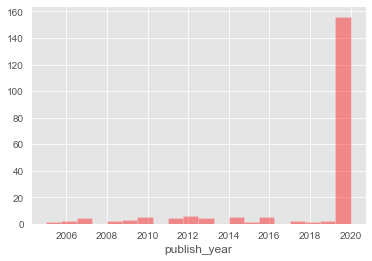

In [18]:
#Set plot style to ggplot
plt.style.use("ggplot")
#Extract publication year from 'Publish_Time' field
meta_df['publish_year']=meta_df['publish_time'].apply(lambda x:  x[:4])

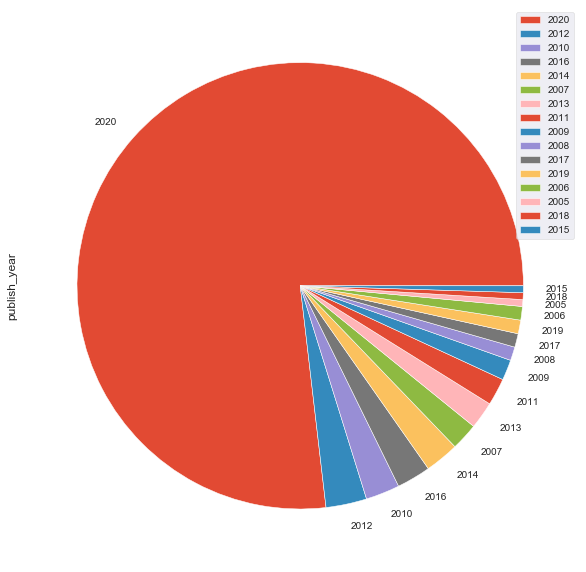

In [19]:
#Visualise publication year data using a pie chart; A majority of the publications were created in the year 2020
meta_df['publish_year'].value_counts().plot(kind = "pie",  figsize=(10, 30) , legend = True)

In [20]:
#A lambda function is run on the title field to do a quick scan of the publication language 
%timeit meta_df['language']= meta_df['title'].apply(lambda x: detect(x))
meta_df['language'].value_counts()

958 ms ± 87.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


en    202
de      1
Name: language, dtype: int64

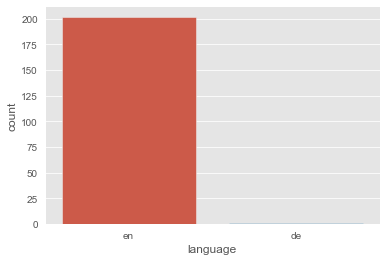

In [22]:
plt.style.use("ggplot")
#Vislualize language data using a countplot. A majority of the documents are created in english
sns.countplot(x='language', data=meta_df)

In [25]:
#####Only English articles from last 2 years are retained
final_meta_df = meta_df[(meta_df['language']=='en')  & ( meta_df['publish_year'] > '2018' )]

In [26]:
print(final_meta_df.shape) #157 publications are retained

(157, 9)


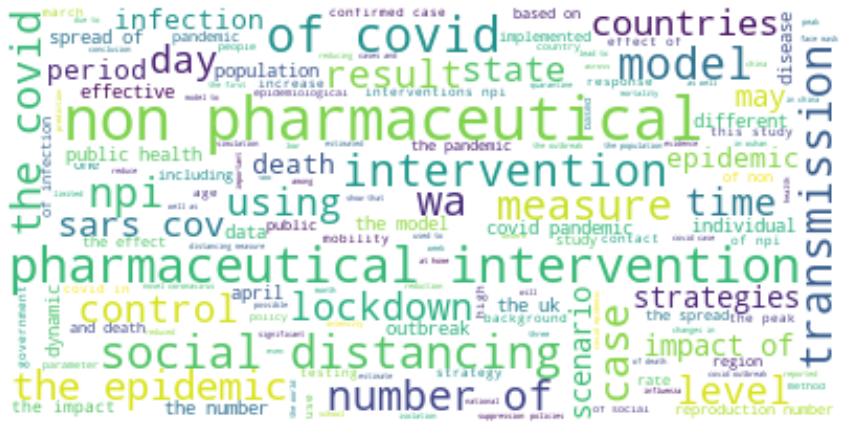

In [33]:
#Append abstract's together to generate word cloud
text = " ".join(abstract for abstract in final_meta_df['abstract'] ) 

# Create and generate a word cloud image: 
wordcloud = WordCloud(background_color="white").generate(text)
 
# Display the generated image:
plt.figure(figsize=[15,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [35]:
#The below function is used to extract body text for each file and append it together
def load_json_doc(file_name ):
      
    body_text = ''
    try:
        with open(file_name) as json_file:
                 json_data = json.load(json_file)
                 for  text in json_data['body_text']:     
                        text = text['text'].strip().replace("\n", " ").replace("\r", " ")
                        text =  text.lower()
                        try: 
                            if len( text) > 0:
                                body_text = body_text + '\n' + text
                        except:
                                   pass
                            
    except IOError: 
          pass
          

    return body_text 
    

In [36]:
file_path =  current_path +'/551982_1230614_bundle_archive/'
print(file_path)

/Users/abhishekjonnavittula/Documents/Kaggle_Challenges/551982_1230614_bundle_archive/


In [37]:
Final_Data =[] 
Store_dataInfo = pd.DataFrame([])

for  index , row  in final_meta_df.iterrows():
            #Some of the publications are spread across multiple JSONs 
            if  row['pdf_json_files' ].find(";") > 0: 
                 file = row['pdf_json_files' ][:row['pdf_json_files' ].find(";")]
            else:    
                 file_name = file_path + row['pdf_json_files'] 
    
            Body_Text =  load_json_doc(file_name )
        
            if len(Body_Text) > 0:
                Final_Data.append(Body_Text)
                l= len(Final_Data)-1
                Store_dataInfo = Store_dataInfo.append(pd.DataFrame({'FileName':  file_name, 'Title' : row['title' ] , 'Body_Text':Body_Text , 'FinalDataIndex': l}, index=[0]), ignore_index=True)
                                
print("Total Text loaded " ,len(Final_Data))
print(Store_dataInfo.info())
print(Store_dataInfo.head(3))


Total Text loaded  157
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   FileName        157 non-null    object
 1   Title           157 non-null    object
 2   Body_Text       157 non-null    object
 3   FinalDataIndex  157 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 5.0+ KB
None
                                                                                                                                                       FileName  \
0  /Users/abhishekjonnavittula/Documents/Kaggle_Challenges/551982_1230614_bundle_archive/document_parses/pdf_json/85c6f63e581817cce1d68e6a5bb856fdbe390d17.json   
1  /Users/abhishekjonnavittula/Documents/Kaggle_Challenges/551982_1230614_bundle_archive/document_parses/pdf_json/c3de717508f4b790f53e9e998ef61c5f27b00ce7.json   
2  /Users/abhishekjonnavittula/Documents/Kaggle_Challenges/551982

In [38]:
##Initialize count vectorizer
cv = CountVectorizer(
                        max_df=0.7, #Ignore terms that occur in 70% of the documents 
                        min_df=0.1, #Ignore terms that occur in less than 10% of the documents 
                        token_pattern='[a-zA-Z]{4,}', #remove works less than 4 characters
                        stop_words='english'# remove english stop words
                    )
### document term matrix
dtm=cv.fit_transform(Final_Data) #initialize the document term matrix


In [39]:
print(len(cv.get_feature_names()))
print(f'Shape Rows by Word {dtm.shape}')

1804
Shape Rows by Word (157, 1804)


In [41]:
LDA = LatentDirichletAllocation(n_components=4,random_state=42)
# This can take awhile, we're dealing with a large amount of documents!
%timeit LDA.fit(dtm)

1.82 s ± 33.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
#Explore words present in the count vectorizer
for i in range(20):
    random_word_id = random.randint(0,len(cv.get_feature_names()))
    print(cv.get_feature_names()[random_word_id])
 

vaccines
hospitalized
organization
removal
going
threshold
apply
taking
illness
quantitative
removal
offer
adjusting
plausible
capture
algorithm
surveillance
occupancy
probably
january


In [44]:
print(f'Total number of clusters:',len(LDA.components_))
# Numerical representation of values present in each of the 4 clusters
print(LDA.components_)

Total number of clusters: 4
[[31.31818035 35.49359524 36.32886485 ... 12.26458631 16.87835501
   0.2703555 ]
 [20.54103298 33.64482042 31.49355876 ...  8.94074681 24.44536207
  31.71705727]
 [19.83744259 47.67918366 42.74870463 ...  6.03432988  8.6987455
  80.36401692]
 [ 0.30334408 30.18240068 18.42887176 ...  9.76033701  9.97753742
  32.64857031]]


In [47]:
# Exploring a single cluster in depth
single_topic = LDA.components_[0]

In [48]:
# Returns the indices that would sort this array in ascending order.
single_topic.argsort()

array([ 356,  103, 1677, ..., 1566, 1155,  993])

In [49]:
print(single_topic.argsort()[0])
print(single_topic.argsort()[-1])

356
993


In [50]:
# Word least representative of this topic
print(single_topic[single_topic.argsort()[0]])
print(cv.get_feature_names()[single_topic.argsort()[0]])

0.25137495956181316
counties


In [51]:
# Word most representative of this topic
# Single_topic[single_topic.argsort()[-1]
cv.get_feature_names()[single_topic.argsort()[-1]] 

'masks'

In [52]:
# Top 15 word indices for this topic:
top_word_indices = single_topic.argsort()[-15:]
print(top_word_indices)

[1056  345  517 1444  301  890  269 1800  992 1295  628 1428 1566 1155
  993]


In [53]:
# Display top 15 words that represent topic 0
for index in top_word_indices:
    if cv.get_feature_names()[index].isalpha():
        print(cv.get_feature_names()[index])

mortality
coronavirus
efficacy
sars
confirmed
isolation
community
york
mask
quarantine
face
risk
state
patients
masks


In [54]:
#Display top 20 words in each topic
for index,topic in enumerate(LDA.components_):
    print(f'THE TOP 20 WORDS FOR TOPIC #{index}')
    print([cv.get_feature_names()[i] for i in topic.argsort()[-20:]])
    print('\n')

THE TOP 20 WORDS FOR TOPIC #0
['economic', 'medical', 'symptoms', 'tracing', 'baseline', 'mortality', 'coronavirus', 'efficacy', 'sars', 'confirmed', 'isolation', 'community', 'york', 'mask', 'quarantine', 'face', 'risk', 'state', 'patients', 'masks']


THE TOP 20 WORDS FOR TOPIC #1
['certified', 'april', 'review', 'states', 'deaths', 'mobility', 'npis', 'peer', 'posted', 'version', 'international', 'holder', 'copyright', 'perpetuity', 'funder', 'granted', 'author', 'medrxiv', 'license', 'preprint']


THE TOP 20 WORDS FOR TOPIC #2
['scenario', 'symptomatic', 'approach', 'distribution', 'critical', 'exponential', 'mean', 'values', 'parameter', 'contacts', 'group', 'value', 'household', 'growth', 'network', 'care', 'dynamics', 'probability', 'parameters', 'models']


THE TOP 20 WORDS FOR TOPIC #3
['npis', 'scenario', 'stochastic', 'suppression', 'region', 'value', 'city', 'strategy', 'strategies', 'parameters', 'seir', 'regions', 'reduction', 'optimal', 'mobility', 'deaths', 'isolation',

In [55]:
#Save topic results
topic_results = LDA.transform(dtm)

In [56]:
topic_results.shape

(157, 4)

In [57]:
print(topic_results.argmax(axis=0))

[147   5 117 124]


In [59]:
topic_results[len(topic_results)-1]

array([0.14813521, 0.31632909, 0.35473664, 0.18079906])

In [60]:
topic_results[len(topic_results)-1].round(2)

array([0.15, 0.32, 0.35, 0.18])

In [61]:
#Display topics for all 157 documents
topic_results.argmax(axis=1)

array([0, 2, 0, 0, 0, 1, 1, 1, 3, 1, 1, 1, 1, 2, 1, 3, 0, 1, 2, 1, 2, 1,
       1, 1, 0, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 0, 0, 1, 1, 2,
       1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 0, 1, 1, 1, 1, 3, 1, 0, 1, 1,
       1, 1, 2, 1, 0, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1, 2, 1,
       2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 3, 2, 2, 3, 3, 0, 2,
       2, 2, 1, 2, 2, 0, 1, 2, 3, 1, 2, 2, 2, 2, 3, 0, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 2, 0, 3, 3, 2, 2, 0, 3, 3, 0, 2, 2, 0, 0, 0, 0,
       0, 2, 2])

In [62]:
#Add topics to publication dataframe
Store_dataInfo['LDAtopic']= topic_results.argmax(axis=1)

In [86]:
#Display title associated with topic 1
Store_dataInfo[Store_dataInfo['LDAtopic']==1][['Title' , 'LDAtopic']].head(15)

,Title,LDAtopic
5,"the effect of inter-city travel restrictions on geographical spread of covid-19: evidence from wuhan, china",1
6,crowding and the epidemic intensity of covid-19 transmission,1
7,a first study on the impact of current and future control measures on the spread of covid-19 in germany,1
9,modeling the effects of non-pharmaceuticalinterventions on covid-19 spread in kenya,1
10,social interventions can lower covid-19 deaths in middle-income countries,1
11,"incidence, clinical outcomes, and transmission dynamics of hospitalized 2019 coronavirus disease among 9,596,321 individuals residing in california and washington, united states: a prospective cohort study",1
12,detection and isolation of asymptomatic individuals can make the difference in covid-19 epidemic management,1
14,the immediate effect of covid-19 policies on social distancing behavior in the united states,1
17,early phase of the covid-19 outbreak in hungary and post-lockdown scenarios,1
19,covid-19 trajectories: monitoring pandemic in the worldwide context,1


# Additional Analysis

The following section showcases topic modeling using Non-Negative Factorization (NMF). The objective was to compare LDA and NMF in terms of the topics that are created by them.

In [87]:
########Non-Negative-Matrix-Factorization; Initialize the TFIDF vectorizer
tfidf = TfidfVectorizer(max_df=0.7, min_df=0.1 ,token_pattern='[a-zA-Z]{4,}', stop_words='english')
tfdtm= tfidf.fit_transform(Final_Data)
tfdtm

<157x1804 sparse matrix of type '<class 'numpy.float64'>'
	with 69940 stored elements in Compressed Sparse Row format>

In [89]:
#Initialize the NMF object
nmf_model = NMF(n_components=4,random_state=42)

In [90]:
# This can take awhile, we're dealing with a large amount of documents!
nmf_model.fit(tfdtm)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=4, random_state=42, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [92]:
len(tfidf.get_feature_names())

1804

In [93]:
#Explore words present in the count vectorizer
for i in range(10):
    random_word_id = random.randint(0,len(tfidf.get_feature_names()))
    print(tfidf.get_feature_names()[random_word_id])

magnitude
vary
wuhan
propagation
active
practically
pathogen
biological
relationships
option


In [94]:
len(nmf_model.components_)

4

In [95]:
nmf_model.components_

array([[0.01180623, 0.01153897, 0.0118008 , ..., 0.00233638, 0.00965136,
        0.00848678],
       [0.00271895, 0.02982353, 0.02614032, ..., 0.00444978, 0.01046465,
        0.0616793 ],
       [0.00623381, 0.00313627, 0.02275704, ..., 0.0035921 , 0.00898947,
        0.00328476],
       [0.02317184, 0.03600896, 0.03197228, ..., 0.02447177, 0.02500254,
        0.        ]])

In [96]:
#Explore top 20 words present in each topic
for index,topic in enumerate(nmf_model.components_):
    print(f'THE TOP 20 WORDS FOR TOPIC #{index}')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-20:]])
    print('\n')

THE TOP 20 WORDS FOR TOPIC #0
['april', 'states', 'asymptomatic', 'review', 'certified', 'reviewed', 'peer', 'npis', 'version', 'international', 'posted', 'holder', 'copyright', 'author', 'funder', 'perpetuity', 'granted', 'medrxiv', 'license', 'preprint']


THE TOP 20 WORDS FOR TOPIC #1
['mean', 'probability', 'regions', 'value', 'values', 'india', 'seir', 'reproduction', 'growth', 'scenario', 'dynamics', 'deaths', 'npis', 'evolution', 'network', 'parameters', 'stochastic', 'mobility', 'models', 'lockdown']


THE TOP 20 WORDS FOR TOPIC #2
['hospitalizations', 'strict', 'tracing', 'elimination', 'isolation', 'mortality', 'burden', 'cumulative', 'coverage', 'entire', 'class', 'quarantine', 'baseline', 'quarantined', 'efficacy', 'state', 'mask', 'face', 'york', 'masks']


THE TOP 20 WORDS FOR TOPIC #3
['children', 'access', 'clinical', 'healthcare', 'contacts', 'respiratory', 'medical', 'households', 'human', 'rural', 'isolation', 'severe', 'sars', 'household', 'viral', 'care', 'wuhan', 

In [97]:
tfdtm.shape

(157, 1804)

In [98]:
tftopic_results = nmf_model.transform(tfdtm)

In [99]:
tftopic_results.shape

(157, 4)

In [100]:
Store_dataInfo['TFIDF_topic']= tftopic_results.argmax(axis=1)

In [101]:
#Comparing topics across LDA and NMF
Store_dataInfo[Store_dataInfo['LDAtopic']==1][['Title' , 'LDAtopic' , 'TFIDF_topic']].head(15)

,Title,LDAtopic,TFIDF_topic
5,"the effect of inter-city travel restrictions on geographical spread of covid-19: evidence from wuhan, china",1,0
6,crowding and the epidemic intensity of covid-19 transmission,1,0
7,a first study on the impact of current and future control measures on the spread of covid-19 in germany,1,0
9,modeling the effects of non-pharmaceuticalinterventions on covid-19 spread in kenya,1,0
10,social interventions can lower covid-19 deaths in middle-income countries,1,0
11,"incidence, clinical outcomes, and transmission dynamics of hospitalized 2019 coronavirus disease among 9,596,321 individuals residing in california and washington, united states: a prospective cohort study",1,3
12,detection and isolation of asymptomatic individuals can make the difference in covid-19 epidemic management,1,0
14,the immediate effect of covid-19 policies on social distancing behavior in the united states,1,0
17,early phase of the covid-19 outbreak in hungary and post-lockdown scenarios,1,0
19,covid-19 trajectories: monitoring pandemic in the worldwide context,1,0
